In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import metapredict as meta
from pysam import FastaFile
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.ExPASy import ScanProsite
from quantiprot.utils.io import load_fasta_file
from quantiprot.utils.feature import Feature, FeatureSet
from quantiprot.metrics.aaindex import get_aa2charge, get_aa2hydropathy, get_aa2volume
from quantiprot.utils.mapping import simplify
from quantiprot.metrics.basic import identity, average, sum_absolute, uniq_count
from quantiprot.utils.sequence import compact
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils.ProtParam import ProtParamData
from sklearn.metrics import roc_curve, roc_auc_score
from sparrow import Protein
from scipy.stats import mannwhitneyu
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import numpy as np
import metapredict as meta

In [6]:
def calculate_auc_with_ci(df, column, label, random_state=42):
    np.random.seed(random_state)  # Set the seed for reproducibility
    
    aucs = []
    pr_aucs = []
    max_f1_scores = []  
    fprs = []  # False Positive Rate
    n_bootstrap = 200
    
    for _ in range(n_bootstrap):
        # Separate the data into positive and negative classes
        positive = df[df[label] == 1]
        negative = df[df[label] == 0]
        min_size = min(len(positive), len(negative))
        positive_resampled = resample(positive, replace=False, n_samples=min_size)
        negative_resampled = resample(negative, replace=False, n_samples=min_size)
        sample = pd.concat([positive_resampled, negative_resampled])
        sample = resample(sample, replace=True)
        sample = sample.dropna(subset=[label, column])
        if sample.empty:
            continue
        try:
            # Calculate AUC and PR AUC
            auc = roc_auc_score(sample[label], sample[column])
            aucs.append(auc)
            pr_auc = average_precision_score(sample[label], sample[column])
            pr_aucs.append(pr_auc)
            
            # Calculate FPR, TPR, and F1 Score at thresholds
            fpr, tpr, thresholds = roc_curve(sample[label], sample[column])
            specificity = 1 - fpr
            f1_scores_at_thresholds = 2 * (tpr * specificity) / (tpr + specificity + 1e-10)  
            max_f1_index = np.argmax(f1_scores_at_thresholds)
            max_f1 = f1_scores_at_thresholds[max_f1_index]
            max_f1_scores.append(max_f1)
            
            # Calculate False Positive Rate (FPR) at max F1 threshold
            fprs.append(fpr[max_f1_index])  # Store FPR at the threshold where F1 is maximized
            
        except ValueError:
            pass
    
    # Calculate Confidence Intervals for metrics
    auc_ci = t.interval(0.95, len(aucs) - 1, loc=np.mean(aucs), scale=sem(aucs))
    pr_auc_ci = t.interval(0.95, len(pr_aucs) - 1, loc=np.mean(pr_aucs), scale=sem(pr_aucs))
    max_f1_ci = t.interval(0.95, len(max_f1_scores) - 1, loc=np.mean(max_f1_scores), scale=sem(max_f1_scores))
    fpr_ci = t.interval(0.95, len(fprs) - 1, loc=np.mean(fprs), scale=sem(fprs))

    return (
        np.mean(aucs), auc_ci,
        np.mean(pr_aucs), pr_auc_ci,
        np.mean(max_f1_scores), max_f1_ci,
        np.mean(fprs), fpr_ci
    )

In [7]:
class get_seq(object):
    def __init__(self, seq, ref, alt, start, pos):
        self.seq =  seq
        self.size = len(self.seq)
        self.index = int(pos) -1
        self.start = int(start)
        self.ref =  ref
        self.alt = alt
        self.ref_size = len(self.ref)
        
    def __iter__(self):
        return self

    def get_ref(self):
        ref_index = self.index - self.start
        print(ref_index)
        str_ref = self.seq[ref_index]
        if str(str_ref) == str(self.ref):
            return True
        else:
            print("Warning: fasta sequence base {0} does not match the input {1} for seq {2} for index {3}".format(str_ref,
                                                                                                          self.ref,
                                                                                                         self.seq, self.index))
    
    def generate_mutant(self):
        #check_ref = self.get_ref()
        pos = self.index - self.start
        mut_seq = str(self.seq[:pos +1]) + str(self.alt) + str(self.seq[pos + 2:])
        #print(self.seq)
        #print(mut_seq)
        return mut_seq

    def generate_del(self):
        mut_seq =  str(self.seq[:self.index + 1]) + str(self.seq[self.index + self.ref_size :])
        return mut_seq

In [8]:
mutation_data_df = pd.read_csv("../output/AF2_Disorder_deleterious_neutral_vus_results_filtered.tsv", sep='\t')
fasta_dir = '/projects/wangc/rohan/missense_prediction/disorder/disorder/alphafold/fasta_download'
mutation_data_df['mutation'] = mutation_data_df['CAVA_PROTREF'] + mutation_data_df['CAVA_PROTPOS'].astype(str) + mutation_data_df['CAVA_PROTALT']
#dbnsfp_disorder_df = pd.read_csv('/projects/wangc/rohan/missense_prediction/disorder/disorder/dbNSFP/dbNSFP4.8a_variant.disorder_genes.tsv', sep='\t')
mutation_data_df = mutation_data_df[mutation_data_df['Class'] != 'VUS']
drop_genes = ['STING1', 'PRDM2', 'PEX5', 'ITGB2', 'NOTCH1', 'PTEN']
mutation_data_df = mutation_data_df[~mutation_data_df['GENES'].isin(drop_genes)]
mutation_data_df = mutation_data_df.groupby(['mutation', 'GENES', 'Class']).first().reset_index()
mutation_data_df

,mutation,GENES,Class,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,...,SCIDNINCL,SCIINCL,SCIREVSTAT,CHROM,GSTART,GEND,TRANSCRIPT_x,TRANSCRIPT_NOV,UNIPROT_ID,within_interval
0,A1011E,TSC1,Neutral,chr9,135772085,207618,G,T,0,.,...,.,.,.,chr9,964,1164,NM_000368.5,NM_000368,Q92574,True
1,A102T,E2F1,Neutral,chr20,32268180,785835,C,T,0,.,...,.,.,.,chr20,1,129,NM_005225.3,NM_005225,Q01094,True
2,A1034T,GLI3,Neutral,chr7,42005571,2937390,C,T,0,.,...,.,.,.,chr7,946,1580,NM_000168.6,NM_000168,P10071,True
3,A1039T,GLI3,Neutral,chr7,42005556,459211,C,T,0,.,...,.,.,.,chr7,946,1580,NM_000168.6,NM_000168,P10071,True
4,A103V,EHMT1,Neutral,chr9,140611300,761602,C,T,0,.,...,.,.,.,chr9,1,523,NM_024757.5,NM_024757,Q9H9B1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198,Y828C,LDLR,Deleterious,chr19,11240282,3704,A,G,0,.,...,.,.,.,chr19,720,860,NM_000527.5,NM_000527,P01130,True
2199,Y828H,LDLR,Deleterious,chr19,11240281,252345,T,C,0,.,...,.,.,.,chr19,720,860,NM_000527.5,NM_000527,P01130,True
2200,Y828S,LDLR,Deleterious,chr19,11240282,226395,A,C,0,.,...,.,.,.,chr19,720,860,NM_000527.5,NM_000527,P01130,True
2201,Y856H,BRCA1,Neutral,chr17,41244982,54604,A,G,0,.,...,.,.,.,chr17,103,1396,NM_007294.4,NM_007294,P38398,True


In [9]:
def load_fasta(fasta, GSTART, GEND):
    fasta_sequences = SeqIO.parse(open(fasta), 'fasta')
    START = GSTART -1
    seq = str(next(fasta_sequences).seq)[START:GEND]
    return seq

def get_wildtype_sequence(row):
    fasta = f"{fasta_dir}/{row['UNIPROT_ID']}.fasta"
    seq = load_fasta(fasta, row['GSTART'], row['GEND'])
    return seq

def get_mutatant_seq(row):
    index = row['CAVA_PROTPOS'] 
    gen_seq = get_seq(row['WT'], row['CAVA_PROTREF'], row['CAVA_PROTALT'], row['GSTART'], index)
    mut_seq = gen_seq.generate_mutant()
    return mut_seq

def get_asphericity(seq):
    p = Protein(seq)
    score = p.predictor.asphericity()
    return score

def get_radius_of_gyration(seq):
    p = Protein(seq)
    score = p.predictor.radius_of_gyration()
    return score

def get_end_to_end_distance(seq):
    p = Protein(seq)
    score = p.predictor.end_to_end_distance()
    return score

def get_scaling_exponent(seq):
    p = Protein(seq)
    score = p.predictor.scaling_exponent()
    return score

def get_prefactor(seq):
    p = Protein(seq)
    score = p.predictor.prefactor()
    return score



In [10]:
#data_df  = mutation_data_df[['mutation', 'Class','UNIPROT_ID','GENES', 'CHROM', 'GSTART', 'GEND', 'CAVA_PROTALT', 'CAVA_PROTPOS', 'CAVA_PROTREF', 'CAVA_TRANSCRIPT']]
#data_df.columns = ['mutation', 'Class','UNIPROT_ID','GENES', 'CHROM', 'GSTART', 'GEND', 'CAVA_PROTALT', 'CAVA_PROTPOS', 'CAVA_PROTREF', 'CAVA_TRANSCRIPT']
#data_df['WT'] = data_df.apply(get_wildtype_sequence, axis=1)
#data_df['mut_seq'] = data_df.apply(get_mutatant_seq, axis=1)
#data_df['wt_asphericity'] = data_df['WT'].apply(lambda x:get_asphericity(x))
#data_df['mut_asphericity'] = data_df['mut_seq'].apply(lambda x:get_asphericity(x))
#data_df['wt_radius_of_gyration'] = data_df['WT'].apply(lambda x:get_radius_of_gyration(x))
#data_df['mut_radius_of_gyration'] = data_df['mut_seq'].apply(lambda x:get_radius_of_gyration(x))
#data_df['wt_end_to_end_distance'] = data_df['WT'].apply(lambda x:get_end_to_end_distance(x))
#data_df['mut_end_to_end_distance'] = data_df['mut_seq'].apply(lambda x:get_end_to_end_distance(x))
#data_df['wt_scaling_exponent'] = data_df['WT'].apply(lambda x:get_scaling_exponent(x))
#data_df['mut_scaling_exponent'] = data_df['mut_seq'].apply(lambda x:get_scaling_exponent(x))
#data_df['wt_prefactor'] = data_df['WT'].apply(lambda x:get_prefactor(x))
#data_df['mut_prefactor'] = data_df['mut_seq'].apply(lambda x:get_prefactor(x))

/tmp/ipykernel_2267184/821896858.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['WT'] = data_df.apply(get_wildtype_sequence, axis=1)
/tmp/ipykernel_2267184/821896858.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['mut_seq'] = data_df.apply(get_mutatant_seq, axis=1)


KeyboardInterrupt: 

In [11]:
#data_df['delta_asphericity'] = data_df['mut_asphericity'] - data_df['wt_asphericity']
#ata_df['delta_radius_of_gyration'] = data_df['mut_radius_of_gyration'] - data_df['wt_radius_of_gyration']
#data_df['delta_end_to_end_distance'] = data_df['mut_end_to_end_distance'] - data_df['wt_end_to_end_distance']
#data_df['delta_scaling_exponent'] = data_df['mut_scaling_exponent'] - data_df['wt_scaling_exponent']
#data_df['delta_prefactor'] = data_df['mut_prefactor'] - data_df['wt_prefactor']
#data_df['abs_delta_asphericity'] = data_df['delta_asphericity'].abs()
#data_df['abs_delta_radius_of_gyration'] = data_df['delta_radius_of_gyration'].abs()
#data_df['abs_delta_end_to_end_distance'] = data_df['delta_end_to_end_distance'].abs()
#data_df['abs_delta_scaling_exponent'] = data_df['delta_scaling_exponent'].abs()
#data_df['abs_delta_prefactor'] = data_df['delta_prefactor'].abs()
#data_df.to_csv("AF2_disorder_albertross_prediction_all.tsv", sep='\t', index=None)
#data_df.to_csv("../output/AF2_disorder_albertross_prediction_all.tsv", sep='\t', index=None)

In [12]:

data_df = pd.read_csv("../output/AF2_disorder_albertross_prediction_all.tsv", sep='\t')
data_keep_df = data_df[data_df['Class'] != 'VUS']

remove_genes = ['STING1', 'PRDM2', 'PEX5', 'ITGB2', 'NOTCH1', 'PTEN']
data_keep_df = data_keep_df[~data_keep_df['GENES'].isin(remove_genes)]
data_keep_df = data_keep_df.groupby(['mutation', 'GENES', 'Class']).first().reset_index()
data_keep_df#.columns

,mutation,GENES,Class,UNIPROT_ID,CHROM,GSTART,GEND,CAVA_PROTALT,CAVA_PROTPOS,CAVA_PROTREF,...,delta_asphericity,delta_radius_of_gyration,delta_end_to_end_distance,delta_scaling_exponent,delta_prefactor,abs_delta_asphericity,abs_delta_radius_of_gyration,abs_delta_end_to_end_distance,abs_delta_scaling_exponent,abs_delta_prefactor
0,A1011E,TSC1,Neutral,Q92574,chr9,964,1164,E,1011,A,...,-0.000456,0.017019,0.131171,-6.664000e-04,0.004899,0.000456,0.017019,0.131171,6.664000e-04,0.004899
1,A102T,E2F1,Neutral,Q01094,chr20,1,129,T,102,A,...,-0.000393,0.013586,0.058442,8.500000e-07,0.006737,0.000393,0.013586,0.058442,8.500000e-07,0.006737
2,A1034T,GLI3,Neutral,P10071,chr7,946,1580,T,1034,A,...,-0.000208,0.005768,0.008315,4.900000e-05,0.000582,0.000208,0.005768,0.008315,4.900000e-05,0.000582
3,A1039T,GLI3,Neutral,P10071,chr7,946,1580,T,1039,A,...,-0.000060,0.015663,0.013506,-1.950000e-05,0.001186,0.000060,0.015663,0.013506,1.950000e-05,0.001186
4,A103V,EHMT1,Neutral,Q9H9B1,chr9,1,523,V,103,A,...,-0.000043,0.013189,0.062256,1.218400e-04,-0.001079,0.000043,0.013189,0.062256,1.218400e-04,0.001079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198,Y828C,LDLR,Deleterious,P01130,chr19,720,860,C,828,Y,...,0.001576,0.275188,0.814741,2.996400e-03,-0.092377,0.001576,0.275188,0.814741,2.996400e-03,0.092377
2199,Y828H,LDLR,Deleterious,P01130,chr19,720,860,H,828,Y,...,0.001318,0.192311,0.475619,1.688860e-03,-0.054022,0.001318,0.192311,0.475619,1.688860e-03,0.054022
2200,Y828S,LDLR,Deleterious,P01130,chr19,720,860,S,828,Y,...,0.001424,0.276003,0.796033,2.910900e-03,-0.087782,0.001424,0.276003,0.796033,2.910900e-03,0.087782
2201,Y856H,BRCA1,Neutral,P38398,chr17,103,1396,H,856,Y,...,0.000180,0.254652,0.531122,2.547000e-04,-0.005214,0.000180,0.254652,0.531122,2.547000e-04,0.005214


In [13]:
#print(data_keep_df['WT'].iloc[1])


def count_low_disorder_bases(sequence, threshold=50):
    """
    Predicts disorder for a given protein sequence and counts residues with disorder < threshold.
    
    :param sequence: Amino acid sequence (string)
    :param threshold: Disorder score threshold (default 0.5)
    :return: Count of residues with disorder score < threshold
    """
    #disorder_scores = meta.predict_disorder(sequence)
    disorder_scores = meta.predict_pLDDT(sequence)
    #print(disorder_scores)
    low_disorder_count = sum(1 for score in disorder_scores if score < threshold)
    return low_disorder_count

#protein_sequence = "MAEAPPRRLGLGPPPGDAPRAELVALTAVQSEQGEAGGGGSPRRLGLLGSPLPPGAPLPGPGSGSGSACGQRSS"  # Replace with actual protein sequence
#disorder_scores = count_low_disorder_bases(protein_sequence)
#data_keep_df['disorder_check'] = data_keep_df['WT'].apply(lambda x:count_low_disorder_bases(x))

In [14]:
#data_keep_df['size'] = data_keep_df['WT'].astype(str).str.len()
#low_disorder_df = data_keep_df[(data_keep_df['disorder_check']> 1)][['Class','GENES', 'GSTART', 'GEND', 'WT', 'size', 'disorder_check']].drop_duplicates()
#high_disorder_df = data_keep_df[data_keep_df['disorder_check'] <  10]
#low_disorder_df.Class.value_counts()

data_keep_df[['abs_delta_asphericity', 'abs_delta_radius_of_gyration']]

,abs_delta_asphericity,abs_delta_radius_of_gyration
0,0.000456,0.017019
1,0.000393,0.013586
2,0.000208,0.005768
3,0.000060,0.015663
4,0.000043,0.013189
...,...,...
2198,0.001576,0.275188
2199,0.001318,0.192311
2200,0.001424,0.276003
2201,0.000180,0.254652


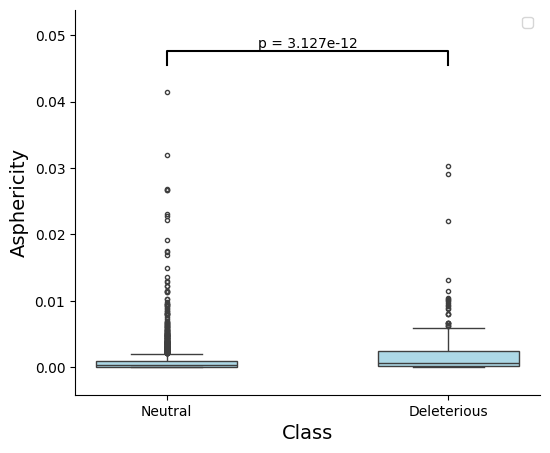

In [19]:
# Apply square root transformation instead of log2
epsilon = 1e-8
data_keep_df['scaled_asphericity'] = np.sqrt(data_keep_df['abs_delta_asphericity'])

# Extract transformed values for plotting
class_a = data_keep_df[data_keep_df['Class'] == 'Deleterious']['abs_delta_asphericity']
class_b = data_keep_df[data_keep_df['Class'] == 'Neutral']['abs_delta_asphericity']

# Mann-Whitney U test using raw values
stat, p_value = mannwhitneyu(class_a, class_b, alternative='two-sided')

# Plot the transformed data using seaborn
plt.figure(figsize=(6, 5))
ax = sns.boxplot(
    x='Class', 
    y='scaled_asphericity', 
    data=data_keep_df,
    width=0.5,
    fliersize=3,
    boxprops={'facecolor': 'lightblue'}
)

# Adjust y-axis limits to spread the data
y_min, y_max = data_keep_df['scaled_asphericity'].min(), data_keep_df['scaled_asphericity'].max()
plt.ylim(y_min - 0.1 * (y_max - y_min), y_max + 0.3 * (y_max - y_min))



# Adding significance annotation
x1, x2 = 0, 1  # x positions for the two categories
y, h, col = y_max + 0.1 * (y_max - y_min), 0.05 * (y_max - y_min), 'k'

plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
plt.text((x1 + x2) * 0.5, y + h, f'p = {p_value:.3e}', ha='center', va='bottom', color=col)

# Labels and formatting
plt.xlabel('Class', fontsize=14)
plt.ylabel('Asphericity', fontsize=14)  # Updated label
plt.legend()
sns.despine()
plt.savefig('association_asphericity_sqrt.png', dpi=300)
plt.show()

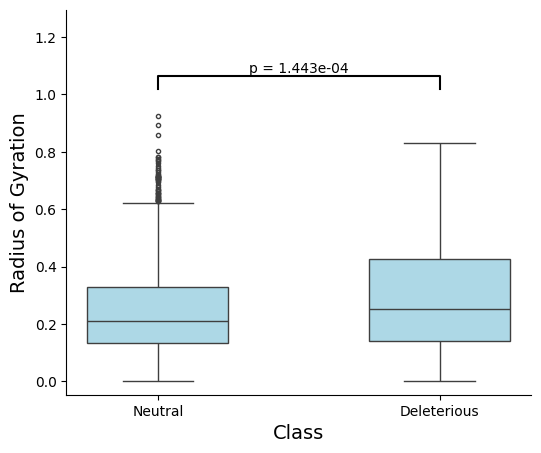

In [50]:
# Performing the Mann-Whitney U Test

data_keep_df['scaled_radius_of_gyration'] = np.sqrt(data_keep_df['abs_delta_radius_of_gyration'])
class_a = data_keep_df[data_keep_df['Class'] == 'Deleterious']['abs_delta_radius_of_gyration']
class_b = data_keep_df[data_keep_df['Class'] == 'Neutral']['abs_delta_radius_of_gyration']

stat, p_value = mannwhitneyu(class_a, class_b, alternative='two-sided')

# Plotting the boxplot using seaborn
plt.figure(figsize=(6, 5))  # Slightly increased figure height
ax = sns.boxplot(
    x='Class', 
    y='scaled_radius_of_gyration', 
    data=data_keep_df,
    width=0.5,  # Makes the box wider
    fliersize=3,
    boxprops={'facecolor': 'lightblue'}# Reduces outlier marker size
)

# Adjusting y-axis limits to enhance distribution visibility
y_min, y_max = data_keep_df['scaled_radius_of_gyration'].min(), data_keep_df['scaled_radius_of_gyration'].max()
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.4 * (y_max - y_min))  # Expands y-range

# Adding significance annotation
x1, x2 = 0, 1  # x positions for the two categories
y, h, col = y_max + 0.1 * (y_max - y_min), 0.05 * (y_max - y_min), 'k'  # Position adjustments

plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)  # Bracket
plt.text((x1 + x2) * 0.5, y + h, f'p = {p_value:.3e}', ha='center', va='bottom', color=col) 

# Labels and formatting
plt.xlabel('Class', fontsize=14)
plt.ylabel('Radius of Gyration', fontsize=14)
sns.despine()
plt.savefig('association_radiusofgyration.png', dpi=300)
plt.show()

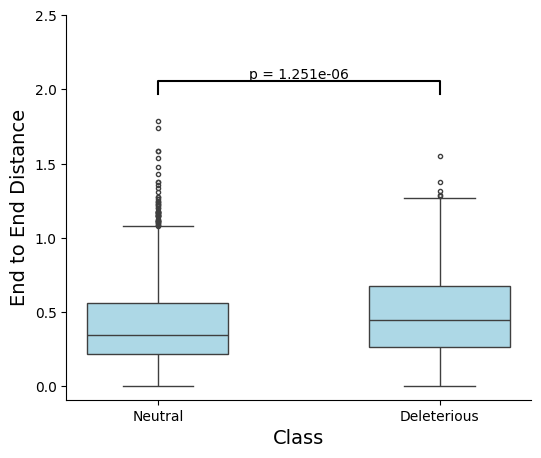

In [51]:
# Performing the Mann-Whitney U Test

data_keep_df['scaled_end_to_end_distance'] = np.sqrt(data_keep_df['abs_delta_end_to_end_distance'])
class_a = data_keep_df[data_keep_df['Class'] == 'Deleterious']['abs_delta_end_to_end_distance']
class_b = data_keep_df[data_keep_df['Class'] == 'Neutral']['abs_delta_end_to_end_distance']

stat, p_value = mannwhitneyu(class_a, class_b, alternative='two-sided')


# Plotting the boxplot using seaborn
plt.figure(figsize=(6, 5))  # Slightly increased figure height
ax = sns.boxplot(
    x='Class', 
    y='scaled_end_to_end_distance', 
    data=data_keep_df,
    width=0.5,  # Makes the box wider
    fliersize=3,
    boxprops={'facecolor': 'lightblue'}# Reduces outlier marker size
)

# Adjusting y-axis limits to enhance distribution visibility
y_min, y_max = data_keep_df['scaled_end_to_end_distance'].min(), data_keep_df['scaled_end_to_end_distance'].max()
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.4 * (y_max - y_min))  # Expands y-range

# Adding significance annotation
x1, x2 = 0, 1  # x positions for the two categories
y, h, col = y_max + 0.1 * (y_max - y_min), 0.05 * (y_max - y_min), 'k'  # Position adjustments

plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)  # Bracket
plt.text((x1 + x2) * 0.5, y + h, f'p = {p_value:.3e}', ha='center', va='bottom', color=col) 

# Labels and formatting
plt.xlabel('Class', fontsize=14)
plt.ylabel('End to End Distance', fontsize=14)
sns.despine()
plt.savefig('association_endtoenddistance.png', dpi=300)
plt.show()


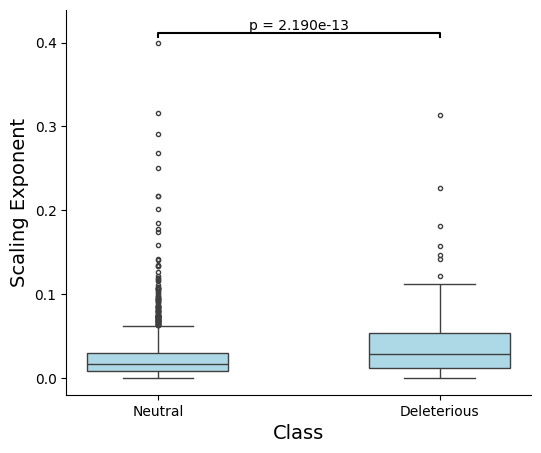

In [52]:
#data_plot_df = data_keep_df[(data_keep_df['abs_delta_scaling_exponent'] < 0.05)]
data_keep_df['scaled_scaling_exponent'] = np.log(data_keep_df['abs_delta_scaling_exponent'])
class_a = data_keep_df[data_keep_df['Class'] == 'Deleterious']['abs_delta_scaling_exponent']
class_b = data_keep_df[data_keep_df['Class'] == 'Neutral']['abs_delta_scaling_exponent']

stat, p_value = mannwhitneyu(class_a, class_b, alternative='two-sided')

# Plotting the boxplot using seaborn
plt.figure(figsize=(6, 5))  # Slightly increased figure height
ax = sns.boxplot(
    x='Class', 
    y='scaled_scaling_exponent', 
    data=data_keep_df,
    width=0.5,
    fliersize=3,# Prevents box overlap  # Removes outliers
    boxprops={'facecolor': 'lightblue'}  # Optional: change box color for better visibility
)


# Adjusting y-axis limits to enhance distribution visibility
y_min, y_max = data_keep_df['scaled_scaling_exponent'].min(), data_keep_df['scaled_scaling_exponent'].max()
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.1 * (y_max - y_min))  # Balanced expansion

# Adding significance annotation
x1, x2 = 0, 1  # x positions for the two categories
y, h, col = y_max + 0.02 * (y_max - y_min), 0.01 * (y_max - y_min), 'k'  # Adjusted bracket placement

plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)  # Bracket
plt.text((x1 + x2) * 0.5, y + h, f'p = {p_value:.3e}', ha='center', va='bottom', color=col) 

# Labels and formatting
plt.xlabel('Class', fontsize=14)
plt.ylabel('Scaling Exponent', fontsize=14)
sns.despine()
plt.savefig('association_scaling_exponent_cleaned.png', dpi=300)
plt.show()

/tmp/ipykernel_84711/2599910799.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot_df['scaled_prefactor'] = np.sqrt(data_plot_df['abs_delta_prefactor'])


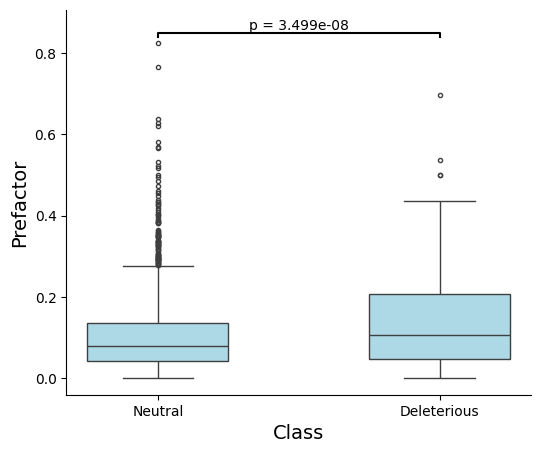

In [53]:
data_plot_df = data_keep_df[(data_keep_df['abs_delta_prefactor'] < 1.0)]
data_plot_df['scaled_prefactor'] = np.sqrt(data_plot_df['abs_delta_prefactor'])
class_a = data_keep_df[data_keep_df['Class'] == 'Deleterious']['abs_delta_prefactor']
class_b = data_keep_df[data_keep_df['Class'] == 'Neutral']['abs_delta_prefactor']

stat, p_value = mannwhitneyu(class_a, class_b, alternative='two-sided')

# Plotting the boxplot using seaborn
plt.figure(figsize=(6, 5))  # Slightly increased figure height
ax = sns.boxplot(
    x='Class', 
    y='scaled_prefactor', 
    data=data_plot_df,
    width=0.5,
    fliersize=3,# Prevents box overlap  # Removes outliers
    boxprops={'facecolor': 'lightblue'}  # Optional: change box color for better visibility
)


# Adjusting y-axis limits to enhance distribution visibility
y_min, y_max = data_plot_df['scaled_prefactor'].min(), data_plot_df['scaled_prefactor'].max()
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.1 * (y_max - y_min))  # Balanced expansion

# Adding significance annotation
x1, x2 = 0, 1  # x positions for the two categories
y, h, col = y_max + 0.02 * (y_max - y_min), 0.01 * (y_max - y_min), 'k'  # Adjusted bracket placement

plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)  # Bracket
plt.text((x1 + x2) * 0.5, y + h, f'p = {p_value:.3e}', ha='center', va='bottom', color=col) 

# Labels and formatting
plt.xlabel('Class', fontsize=14)
plt.ylabel('Prefactor', fontsize=14)
sns.despine()
plt.savefig('association_prefactor.png', dpi=300)
plt.show()

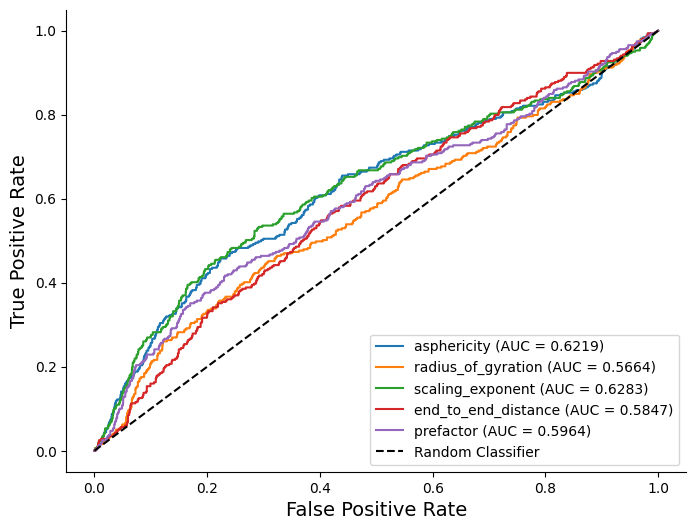

In [54]:
# Convert class to binary labels
data_keep_df['label'] = data_keep_df['Class'].map({'Deleterious': 1, 'Neutral': 0})

# Features to evaluate
features = [
    'abs_delta_asphericity',
    'abs_delta_radius_of_gyration',
    'abs_delta_scaling_exponent',
    'abs_delta_end_to_end_distance',
    'abs_delta_prefactor'
]

renamed_features = {feature: feature.replace("abs_delta_", "") for feature in features}
data_keep_df = data_keep_df.rename(columns=renamed_features)
features = list(renamed_features.values())
plt.figure(figsize=(8, 6))

# Plot ROC curves for each feature
for feature in features:
    true_labels = data_keep_df['label']
    predicted_probs = data_keep_df[feature]
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    auc = roc_auc_score(true_labels, predicted_probs)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{feature} (AUC = {auc:.4f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')  # Diagonal line
#plt.title('ROC Curves for Features')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right')
#plt.grid()
sns.despine()
plt.savefig("AUC_of_pidrc.png", dpi=300)
plt.show()

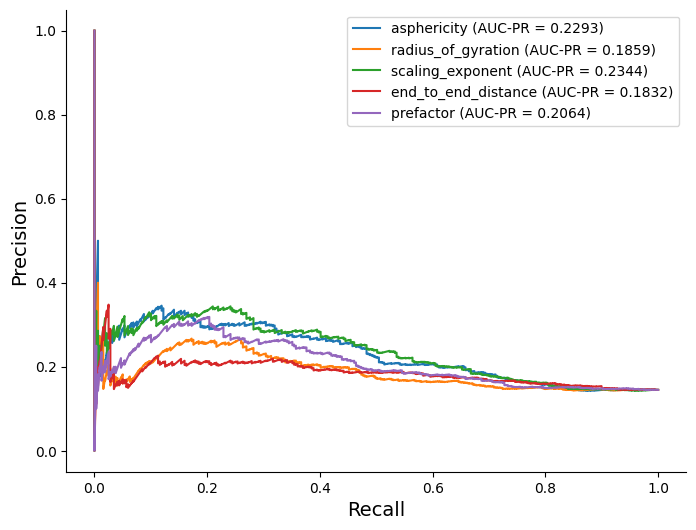

In [55]:
from sklearn.metrics import precision_recall_curve, auc
plt.figure(figsize=(8, 6))

for feature in features:
    true_labels = data_keep_df['label']  # Replace 'Class' with the binary label column
    predicted_probs = data_keep_df[feature]
    
    # Compute Precision-Recall curve and AUC-PR
    precision, recall, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(recall, precision)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, label=f'{feature} (AUC-PR = {pr_auc:.4f})')

# Plot settings
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision',fontsize=14)
plt.legend(loc='upper right')  # Moved legend to top right
sns.despine()
plt.savefig("AUCPR_of_pidrc.png", dpi=300)
plt.show()

In [56]:
data_chrom_genes_df = data_df[['CHROM', 'GENES']]
data_chrom_genes_df = data_chrom_genes_df.drop_duplicates()
data_chrom_genes_df.to_csv("AF2_disorder_genes_chrom.tsv", sep='\t', index=None)

In [57]:
data_df.to_csv('../output/AF2_disorder_albatross_features.csv', index=None)
data_df.columns

Index(['mutation', 'Class', 'UNIPROT_ID', 'GENES', 'CHROM', 'GSTART', 'GEND',
       'CAVA_PROTALT', 'CAVA_PROTPOS', 'CAVA_PROTREF', 'CAVA_TRANSCRIPT', 'WT',
       'mut_seq', 'wt_asphericity', 'mut_asphericity', 'wt_radius_of_gyration',
       'mut_radius_of_gyration', 'wt_end_to_end_distance',
       'mut_end_to_end_distance', 'wt_scaling_exponent',
       'mut_scaling_exponent', 'wt_prefactor', 'mut_prefactor',
       'delta_asphericity', 'delta_radius_of_gyration',
       'delta_end_to_end_distance', 'delta_scaling_exponent',
       'delta_prefactor', 'abs_delta_asphericity',
       'abs_delta_radius_of_gyration', 'abs_delta_end_to_end_distance',
       'abs_delta_scaling_exponent', 'abs_delta_prefactor'],
      dtype='object')

In [20]:
ref_list = list(set(data_df.WT.tolist()))
with open('disorder_ref_seq.list', 'w+') as fout:
    for i in ref_list:
        fout.write(i + '\n')

In [21]:
mut_list = list(set(data_df.mut_seq.tolist()))

with open('disorder_mut_seq.list', 'w+') as fout:
    for i in mut_list:
        fout.write(i + '\n')
#data_df.columns